Using Voronoi partitioning for region division.
DARP Success.
Original: 4 pairs
Improved: 3 pairs
Difference: -1


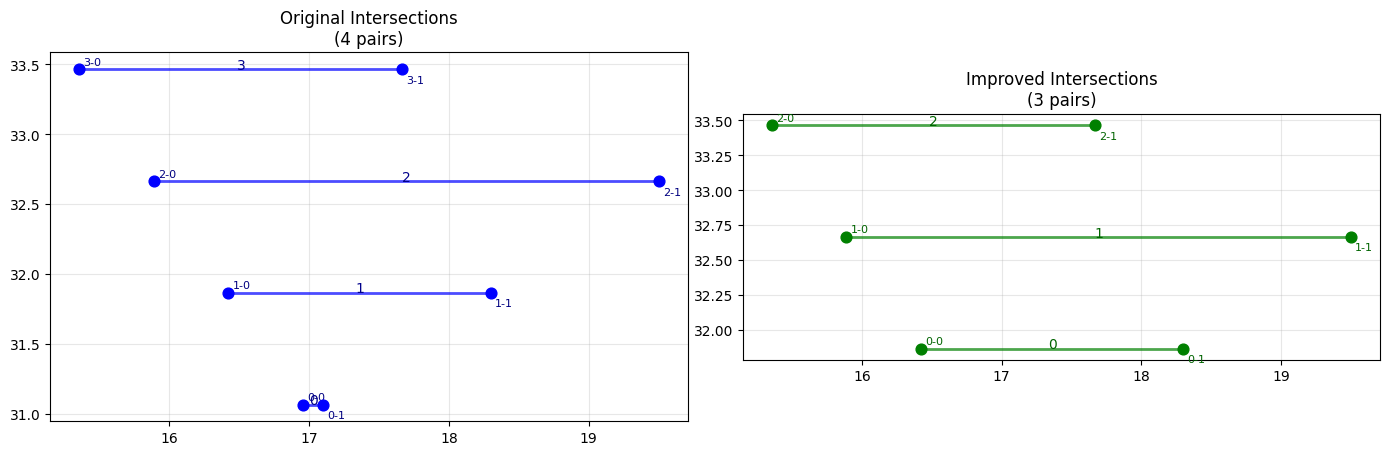

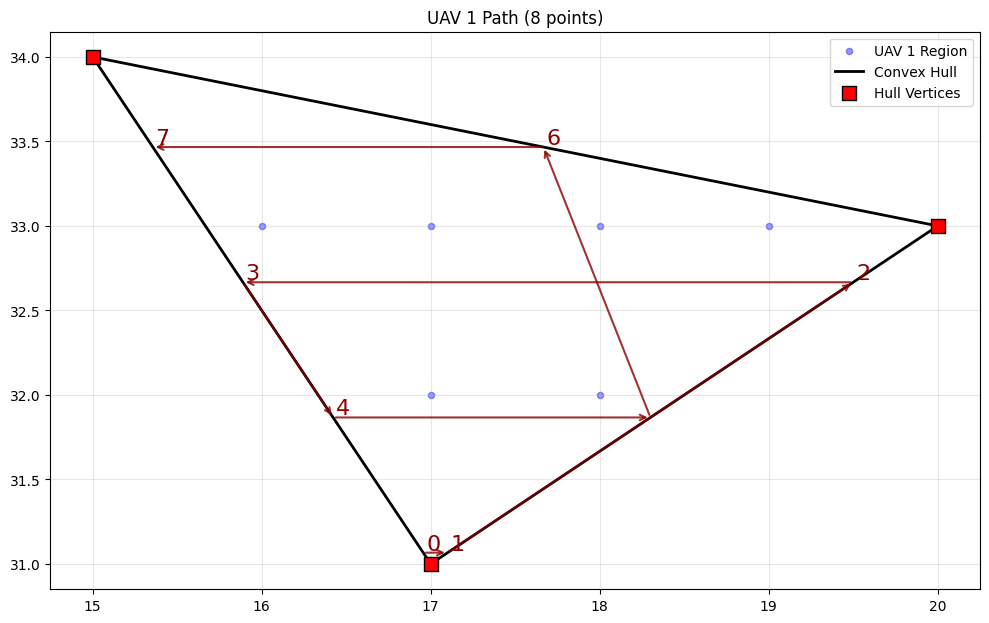

UAV 1: 8 path points
Original: 1 pairs
Improved: 1 pairs
Difference: 0


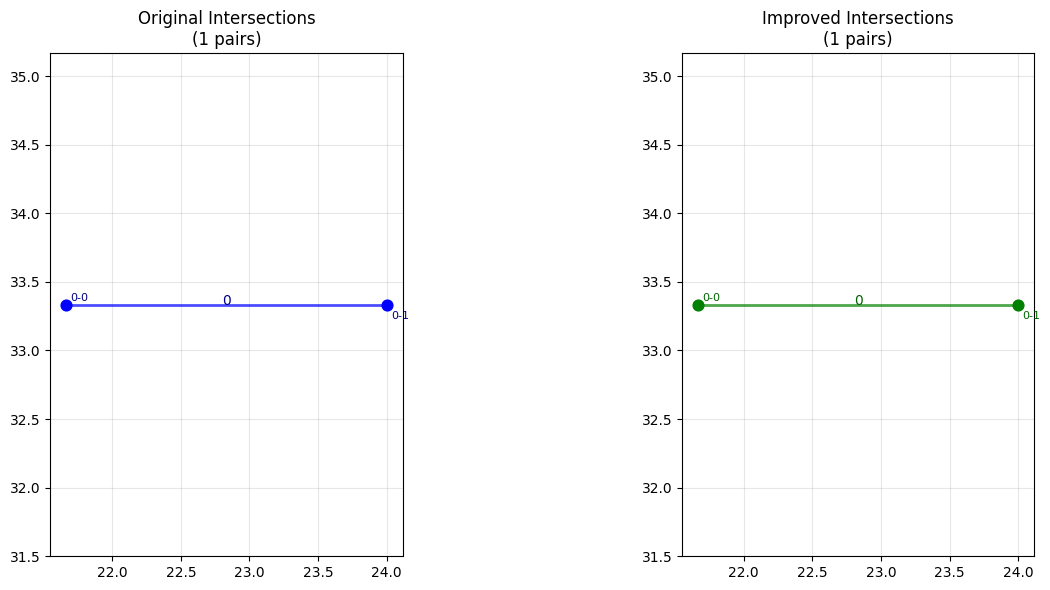

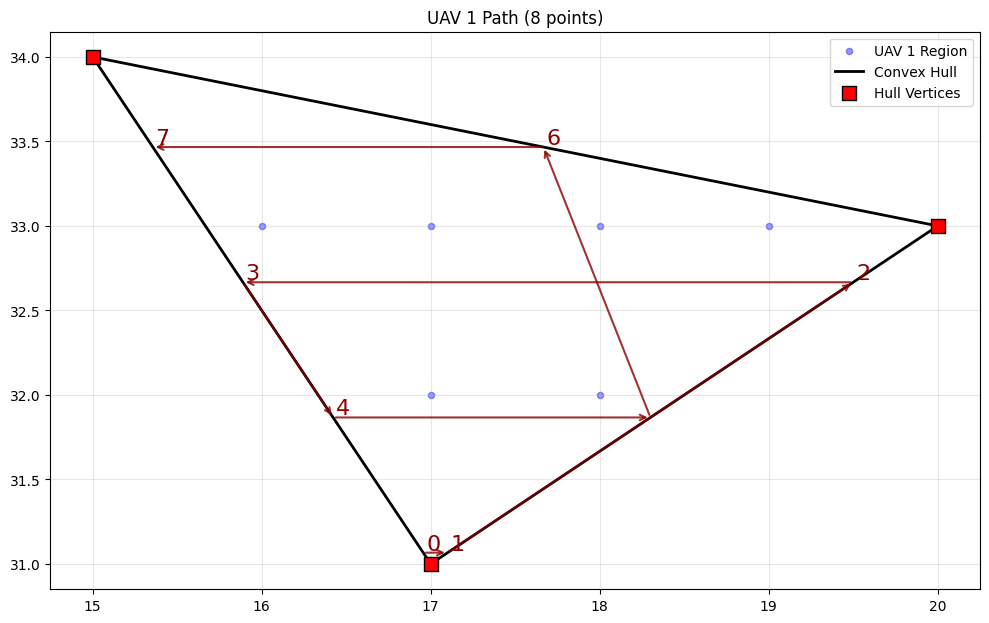

UAV 1: 8 path points


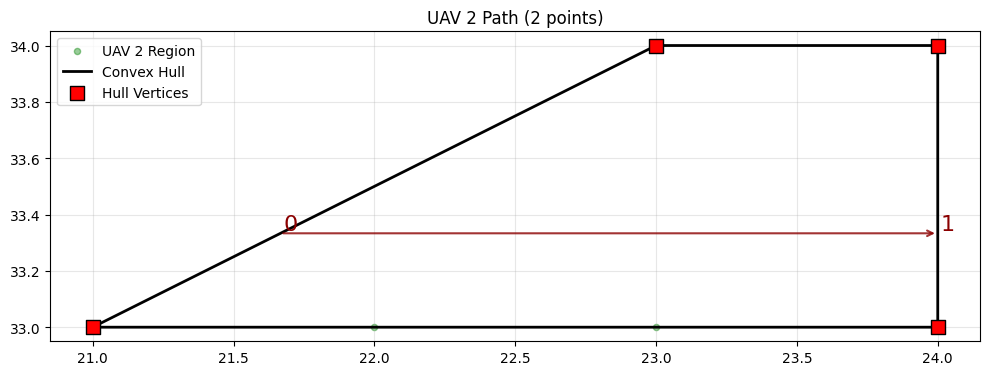

UAV 2: 2 path points
Original: 6 pairs
Improved: 6 pairs
Difference: 0


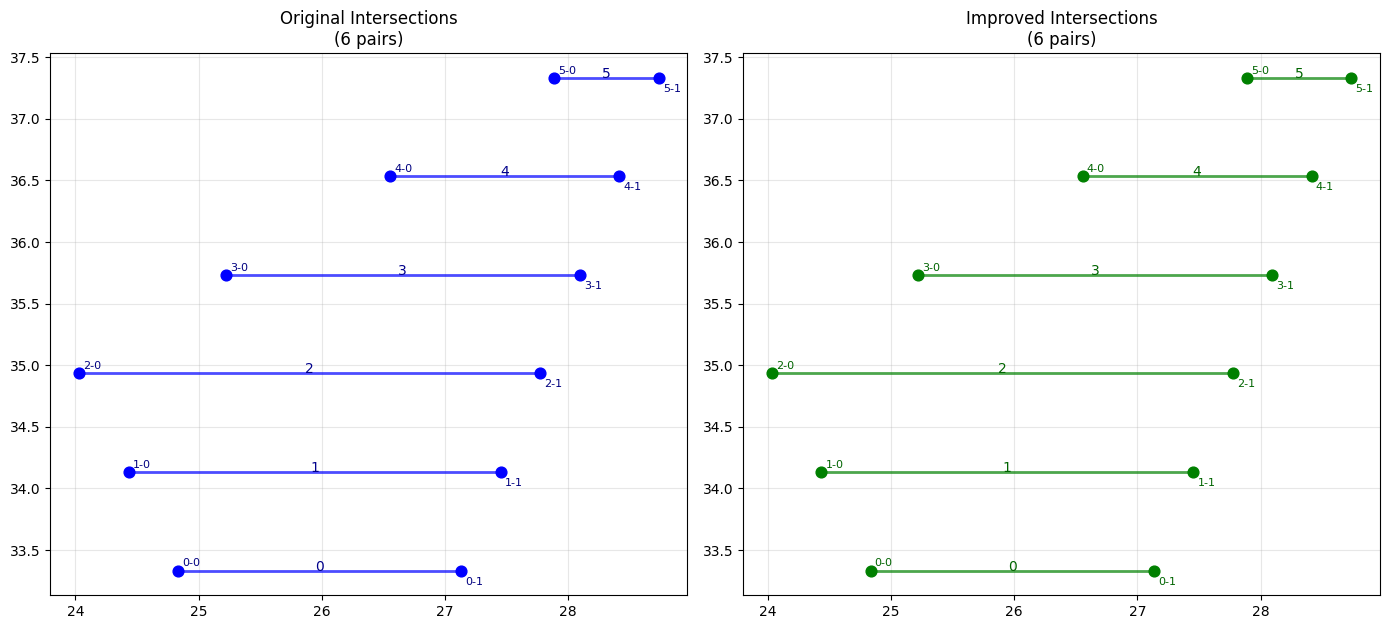

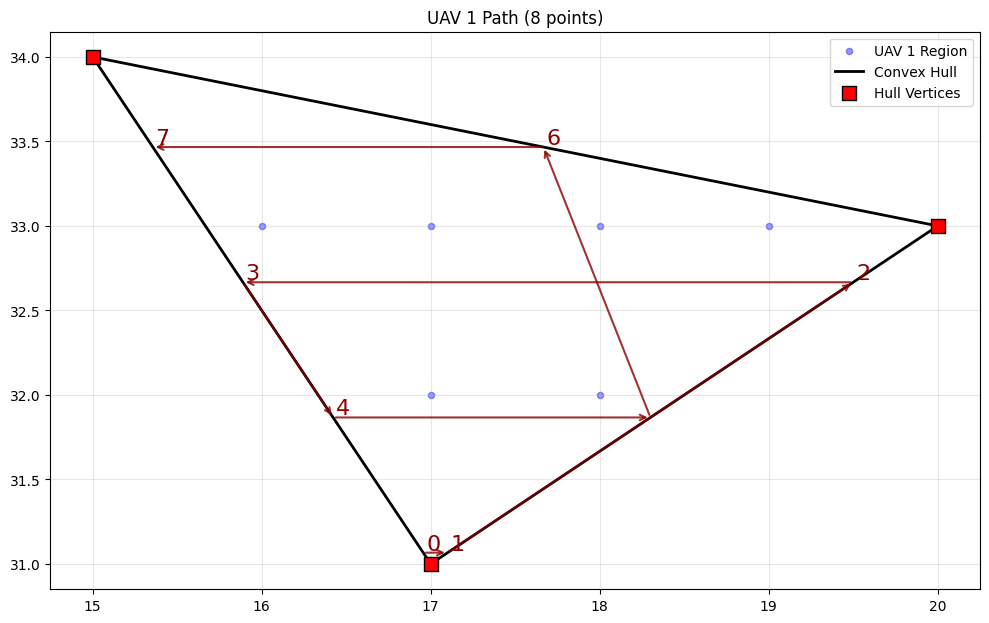

UAV 1: 8 path points


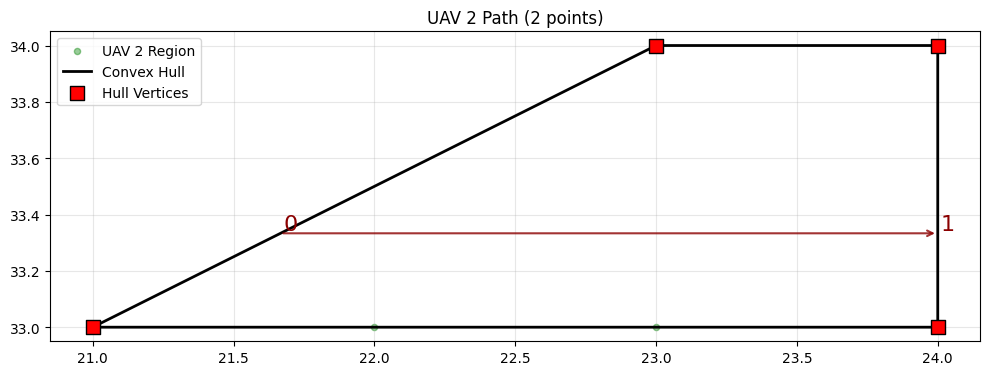

UAV 2: 2 path points


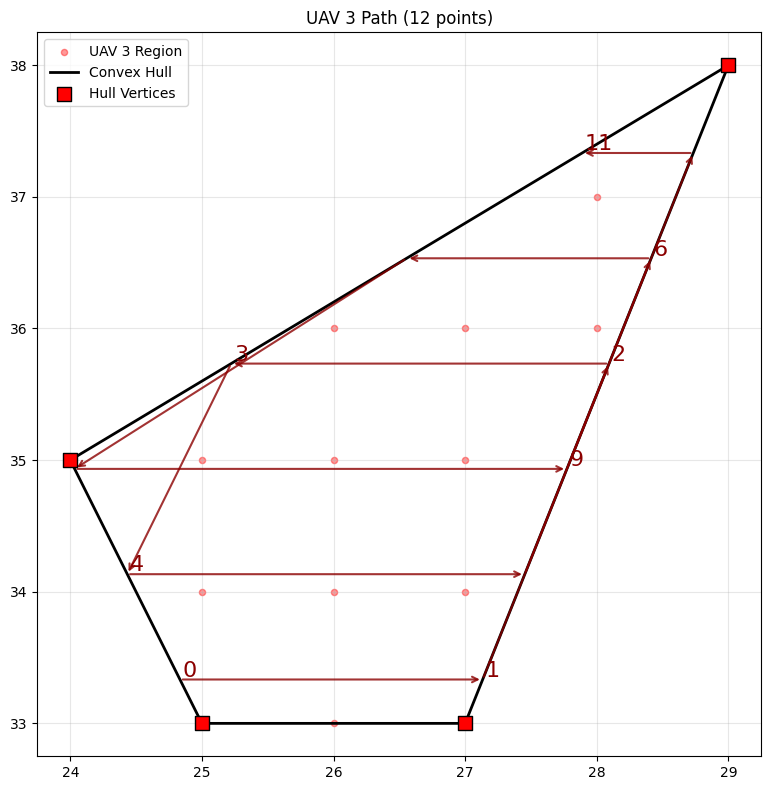

UAV 3: 12 path points


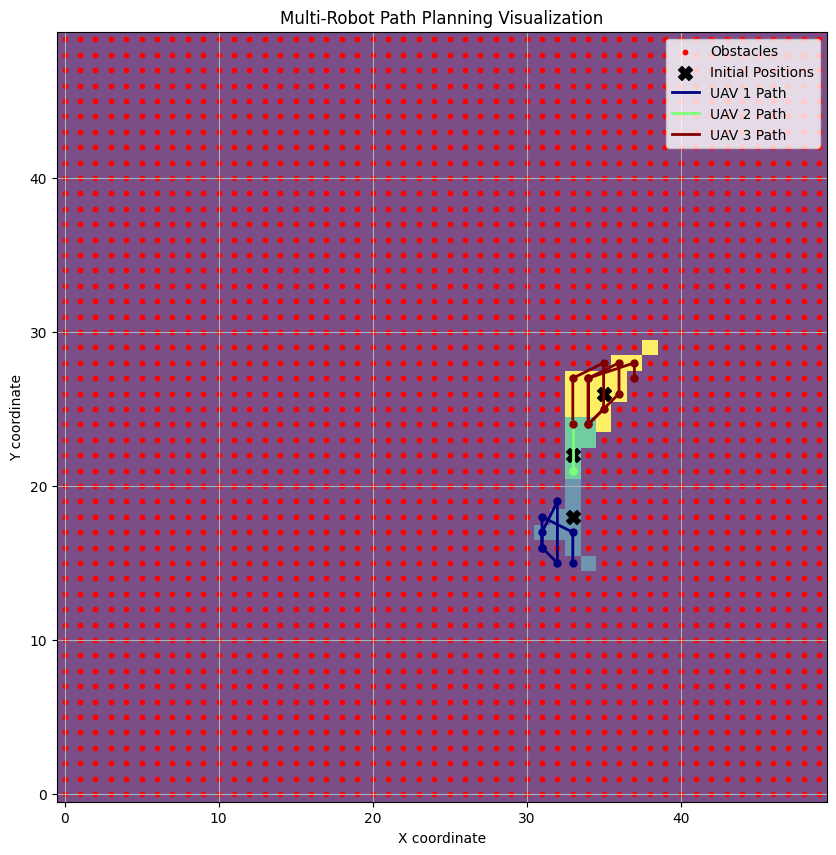


Execution time: 4.2333 seconds

Generated Results:
  - AVS ID: 1, Waypoint Count: 10
  - AVS ID: 2, Waypoint Count: 10
  - AVS ID: 3, Waypoint Count: 10


In [7]:
import random
import time
from copy import deepcopy
from typing import Dict

import numpy as np
from PIL import Image
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean
# skimage.draw에서 disk 함수를 추가로 import 합니다.
from skimage.draw import polygon, disk
from skimage.transform import resize
import matplotlib.pyplot as plt
import math


# ==========================================================================================
# 기존 코드의 의존성을 해결하기 위한 모의(mock) 클래스 및 함수
# ==========================================================================================
class MockManager:
    def __init__(self):
        class Boundary:
            vertices = [
                (36.3, 127.3),
                (36.3, 127.4),
                (36.4, 127.4),
                (36.4, 127.3),
            ]
        class PolygonArea:
            # 이 부분은 이제 사용되지 않습니다.
            vertices = []
        class MissionInitInfo:
            surv_alt = 100
            speed = 10
        class AvsInfo:
            def __init__(self, avs_id, system_group_id):
                self.avs_id = avs_id
                self.system_group_id = system_group_id

        self.mp_input = type("MissionPlanInput", (), {})()
        self.mp_input.boundary = Boundary()
        self.mp_input.polygon_area = PolygonArea()
        self.mp_input.mission_init_info = MissionInitInfo()
        self.mp_input.avs_info_dict = {
            1: AvsInfo(1, 1),
            2: AvsInfo(2, 1),
            3: AvsInfo(3, 1),
        }
        self.avs_to_available_task_dict = {1: ["S"], 2: ["S"], 3: ["S"]}
        self.mp_input_lla = self
        self.avs_info_dict = {
            1: {"pos": (36.31, 127.31, 100)},
            2: {"pos": (36.38, 127.32, 100)},
            3: {"pos": (36.35, 127.38, 100)},
        }

class SmpMode:
    SURV = "SURV"

class SurveillanceSelectionResult:
    def __init__(self, avs_id, system_group_id, smp_mode, speed, waypoint_count, waypoints):
        self.avs_id = avs_id
        self.system_group_id = system_group_id
        self.smp_mode = smp_mode
        self.speed = speed
        self.waypoint_count = waypoint_count
        self.waypoints = waypoints

# 상수 정의
ALT_REF = 100
FOV_LEN = 50
SURV_TURN_RADIUS = 25

def get_avail_avs(avs_to_avail_task, criteria, avs_info_dict):
    avs_list = list(avs_to_avail_task.keys())
    avs_pos_list = [avs_info_dict.get(i)["pos"][:2] for i in avs_list]
    return avs_list, avs_pos_list

def create_mesh(manager, top_left, top_right, bottom_right, bottom_left):
    xs = np.linspace(top_left[1], top_right[1], 100)
    ys = np.linspace(bottom_right[0], top_right[0], 100)
    return np.meshgrid(xs, ys)

def get_coordinate_array(xs, ys, alt):
    return np.vstack([xs, ys, np.full_like(xs, alt)]).T

# ==========================================================================================
# ✨ 새로운 기능: 무작위 장애물 영역 생성 함수
# ==========================================================================================
def generate_random_obstacle_shape(grid_size: int) -> list:
    """
    그리드 내에 무작위 모양(원 또는 다각형)의 장애물 영역을 생성합니다.

    :param grid_size: 그리드의 한 변의 크기
    :return: 장애물 위치 인덱스 리스트
    """
    shape_type = random.choice(['polygon', 'circle'])
    obs_coords = []

    if shape_type == 'polygon':
        # 3~8개의 꼭짓점을 가진 다각형을 생성합니다.
        num_vertices = random.randint(3, 8)
        center_x = grid_size / 2
        center_y = grid_size / 2
        
        # 다각형이 너무 작거나 크지 않도록 반지름 범위를 설정합니다.
        radius_min = grid_size / 6
        radius_max = grid_size / 3
        
        angles = sorted([random.uniform(0, 2 * math.pi) for _ in range(num_vertices)])
        vertices_r = []
        vertices_c = []
        for angle in angles:
            radius = random.uniform(radius_min, radius_max)
            r = int(center_y + radius * math.sin(angle))
            c = int(center_x + radius * math.cos(angle))
            vertices_r.append(max(0, min(grid_size - 1, r)))
            vertices_c.append(max(0, min(grid_size - 1, c)))
        
        rr, cc = polygon(vertices_r, vertices_c)
        obs_coords = np.array([rr, cc]).T

    elif shape_type == 'circle':
        # 무작위 중심점과 반지름을 가진 원을 생성합니다.
        radius = random.randint(int(grid_size / 8), int(grid_size / 4))
        center_r = random.randint(radius, grid_size - 1 - radius)
        center_c = random.randint(radius, grid_size - 1 - radius)
        
        rr, cc = disk((center_r, center_c), radius)
        obs_coords = np.array([rr, cc]).T
    
    # 장애물 좌표를 1차원 인덱스로 변환하여 반환합니다.
    obs_pos = [r * grid_size + c for r, c in obs_coords]
    return obs_pos

# ==========================================================================================
# 원본 코드 (일부 수정됨)
# ==========================================================================================

class Darp:
    def __init__(self, nx, ny, notEqualPortions, initial_positions, portions, obs_pos, visualization,
                 max_iter, cc_variation, random_level, d_cells, importance):
        self.nx = nx
        self.ny = ny
        self.num_uavs = len(initial_positions)
        self.initial_positions = initial_positions
        self.obs_pos = obs_pos
        self.max_iter = max_iter

        self.grid = np.zeros((ny, nx))
        for obs in obs_pos:
            row, col = obs // nx, obs % nx
            if 0 <= row < ny and 0 <= col < nx:
                self.grid[row, col] = -1

        self.assg_mat = np.full((ny, nx), -1, dtype=int)
        free_cells = np.argwhere(self.grid != -1)
        
        initial_coords = np.array([[pos // nx, pos % nx] for pos in initial_positions])
        
        for y, x in free_cells:
            distances = np.linalg.norm(initial_coords - np.array([y, x]), axis=1)
            self.assg_mat[y, x] = np.argmin(distances)

    def divide_regions(self):
        print("Using Voronoi partitioning for region division.")
        return True, 0

class PolygonGridProjector:
    def __init__(self, grid_size):
        self.grid_size = grid_size

    def project_in_pos_with_clearance(self, obs_pos, in_pos, min_clearance):
        return in_pos

def turns(paths):
    return {"paths": paths}

class MultiRobotPathPlanner_ADD4:
    def __init__(
        self,
        nx,
        ny,
        notEqualPortions,
        initial_positions,
        portions,
        obs_pos,
        visualization,
        map_roi,
        turn_radius,
        fov_len,
        MaxIter=80000,
        CCvariation=0.01,
        randomLevel=0.0001,
        dcells=2,
        importance=False,
    ):
        self.darp_instance = Darp(
            nx,
            ny,
            notEqualPortions,
            initial_positions,
            portions,
            obs_pos,
            visualization,
            max_iter=MaxIter,
            cc_variation=CCvariation,
            random_level=randomLevel,
            d_cells=dcells,
            importance=importance,
        )

        self.turn_radius = turn_radius
        self.DARP_success, self.iterations = self.darp_instance.divide_regions()

        if not self.DARP_success:
            print("DARP did not manage to find a solution for the given configuration!")
        else:
            print("DARP Success.")
            l_bin = self.calculate_grid_size(map_roi, nx, ny)

            s_alpha = turn_radius / l_bin
            s_alpha = 0

            resize_shape = (nx, ny)
            resized_grid = resize(
                self.darp_instance.assg_mat, resize_shape, order=0, preserve_range=True, anti_aliasing=False
            ).astype(int)
            
            self.hull_grids = []
            self.shull_grids = []
            self.circ_paths = []
            self.best_case = dict()
            self.best_case["paths"] = []

            # temp =======================
            all_coords_list = []
            all_hull_coords_list = []  
            all_paths_list = []
            # temp =======================

            for value in range(self.darp_instance.num_uavs):
                mask = resized_grid == value
                coords = np.column_stack(np.where(mask))
                
                if coords.shape[0] < 3:
                    self.circ_paths.append([])
                    self.hull_grids.append(np.full(resized_grid.shape, -1))
                    self.shull_grids.append(np.full(resized_grid.shape, -1))
                    continue

                hull = ConvexHull(coords)
                hull_coords = coords[hull.vertices]
                hull_grid = np.full(resized_grid.shape, -1)
                rr, cc = polygon(hull_coords[:, 0], hull_coords[:, 1], resized_grid.shape)
                hull_grid[rr, cc] = value
                self.hull_grids.append(hull_grid)

                shull_grid = np.full(resized_grid.shape, -1)
                shull_grid[rr, cc] = value
                self.shull_grids.append(shull_grid)

                hull_edges = []
                for simplex in hull.simplices:
                    hull_edges.append((coords[simplex[0]], coords[simplex[1]]))
                
                mean = np.mean(coords, axis=0)
                centroid_points = coords - mean
                # cov_matrix = np.cov(centroid_points.T)
                # eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
                # major_axis = eigenvectors[:, np.argmax(eigenvalues)]
                # minor_axis = eigenvectors[:, np.argmin(eigenvalues)]
                major_axis = np.array([1.0, 0.0]) # 가로 방향은 x, y 위치를 바꾸기
                minor_axis = np.array([0.0, 1.0])

                hull_points = coords[hull.vertices]
                projected_points = hull_points @ minor_axis
                max_grid = np.max(projected_points) - np.min(projected_points)
                overlap_margin = 0.2
                s_beta = (fov_len / l_bin) * (1 - overlap_margin) if l_bin > 0 else 1

                perpendicular_axis = np.array([-major_axis[1], major_axis[0]])
                line_count = int(max_grid / s_beta + 1) if s_beta > 0 else 1
                line_spacing = s_beta
                lines = []

                for i in range(-line_count // 2, line_count // 2 + 1):
                    offset = perpendicular_axis * (i * line_spacing)
                    point_on_line = mean + offset
                    lines.append((point_on_line, major_axis))

                intersections = []
                for line_point, direction in lines:
                    direction = direction / np.linalg.norm(direction)
                    line_intersections = []
                    for edge_start, edge_end in hull_edges:
                        intersection = self.line_edge_intersection(line_point, direction, edge_start, edge_end)
                        if intersection is not None:
                            line_intersections.append(intersection)
                    
                    if len(line_intersections) > 1:
                        line_intersections.sort(key=lambda p: np.dot(p - line_point, direction))
                        intersections.append((line_intersections[0], line_intersections[-1]))
                intersections_improved = self.improved_intersection_logic(lines, hull_edges, hull_coords)
                self.compare_intersections(intersections, intersections_improved)


                # path = []
                # reverse = False
                # for pair in intersections:
                #     if reverse:
                #         path.extend([pair[1], pair[0]])
                #     else:
                #         path.extend(pair)
                #     reverse = not reverse
                # 기존 코드를 다음과 같이 교체:

                
                path = []
                if len(intersections) > 0:
                    mid_point = len(intersections) // 2
                    max_lines = max(mid_point, len(intersections) - mid_point)
                    
                    for i in range(max_lines):
                        # 1파트 라인
                        if i < mid_point:
                            pair1 = intersections[i]
                            path.extend([pair1[0], pair1[1]])
                        
                        # 2파트 라인
                        part2_idx = mid_point + i
                        if part2_idx < len(intersections):
                            pair2 = intersections[part2_idx]
                            
                            # 남는 라인들은 정방향으로 처리
                            if i >= mid_point:  # 1파트가 끝난 후 남은 라인들
                                path.extend([pair2[0], pair2[1]])  # 정방향
                            else:
                                path.extend([pair2[1], pair2[0]])  # 역방향

                # 데이터 저장 (temp)
                all_coords_list.append(coords)
                all_hull_coords_list.append(hull_coords)
                all_paths_list.append(path)
                self.plot_all_robots_paths_separately(all_coords_list, all_hull_coords_list, all_paths_list)

                
                self.circ_paths.append(path)
            
            self.best_case["paths"] = [[(int(p[0]), int(p[1])) for p in path] for path in self.circ_paths]

    def compare_intersections(self, intersections, intersections_improved):
        """
        intersections와 intersections_improved를 간단히 비교 시각화
        
        Args:
            intersections: 기존 방식 교점 pairs [(point1, point2), ...]
            intersections_improved: 개선된 방식 교점 pairs [(point1, point2), ...]
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # 왼쪽: 기존 intersections
        ax1.set_title(f'Original Intersections\n({len(intersections)} pairs)')
        for i, pair in enumerate(intersections):
            x_vals = [pair[0][0], pair[1][0]]
            y_vals = [pair[0][1], pair[1][1]]
            
            # 교점 표시
            ax1.scatter(x_vals, y_vals, color='blue', s=60, marker='o', zorder=5)
            # 교점 연결선
            ax1.plot(x_vals, y_vals, 'blue', linewidth=2, alpha=0.7, zorder=3)
            # 선 번호
            ax1.annotate(f'{i}', ((x_vals[0] + x_vals[1]) / 2, (y_vals[0] + y_vals[1]) / 2),
                         fontsize=10, color='darkblue', ha='center', zorder=6)
            # 점 번호 (pair별로 0,1 표시)
            ax1.annotate(f'{i}-0', (x_vals[0], y_vals[0]), fontsize=8, color='navy',
                         xytext=(3, 3), textcoords='offset points')
            ax1.annotate(f'{i}-1', (x_vals[1], y_vals[1]), fontsize=8, color='navy',
                         xytext=(3, -10), textcoords='offset points')
        
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # 오른쪽: 개선된 intersections_improved
        ax2.set_title(f'Improved Intersections\n({len(intersections_improved)} pairs)')
        for i, pair in enumerate(intersections_improved):
            x_vals = [pair[0][0], pair[1][0]]
            y_vals = [pair[0][1], pair[1][1]]
            
            # 교점 표시
            ax2.scatter(x_vals, y_vals, color='green', s=60, marker='o', zorder=5)
            # 교점 연결선
            ax2.plot(x_vals, y_vals, 'green', linewidth=2, alpha=0.7, zorder=3)
            # 선 번호
            ax2.annotate(f'{i}', ((x_vals[0] + x_vals[1]) / 2, (y_vals[0] + y_vals[1]) / 2),
                         fontsize=10, color='darkgreen', ha='center', zorder=6)
            # 점 번호
            ax2.annotate(f'{i}-0', (x_vals[0], y_vals[0]), fontsize=8, color='darkgreen',
                         xytext=(3, 3), textcoords='offset points')
            ax2.annotate(f'{i}-1', (x_vals[1], y_vals[1]), fontsize=8, color='darkgreen',
                         xytext=(3, -10), textcoords='offset points')
        
        ax2.grid(True, alpha=0.3)
        ax2.set_aspect('equal')
        
        plt.tight_layout()
        
        # 간단한 통계 출력
        print(f"Original: {len(intersections)} pairs")
        print(f"Improved: {len(intersections_improved)} pairs")
        print(f"Difference: {len(intersections_improved) - len(intersections)}")
        
        plt.show()


    def filter_hull_vertex_intersections(self, line_intersections, hull_coords, min_distance_threshold=1.5):
        """
        Hull 꼭짓점과 너무 가까운 교점들을 필터링합니다.
        
        Args:
            line_intersections: 라인과 hull edge들의 교점 리스트
            hull_coords: Hull 꼭짓점들의 좌표
            min_distance_threshold: 꼭짓점과의 최소 거리 (격자 단위)
        
        Returns:
            filtered_intersections: 필터링된 교점 리스트
        """
        if len(line_intersections) <= 2:
            return line_intersections
        
        filtered_intersections = []
        
        for intersection in line_intersections:
            # 각 hull 꼭짓점과의 거리 계산
            distances_to_vertices = []
            for vertex in hull_coords:
                distance = np.linalg.norm(intersection - vertex)
                distances_to_vertices.append(distance)
            
            # 가장 가까운 꼭짓점과의 거리가 threshold보다 크면 유지
            min_distance_to_vertex = min(distances_to_vertices)
            if min_distance_to_vertex > min_distance_threshold:
                filtered_intersections.append(intersection)
        
        return filtered_intersections
    
    def remove_duplicate_intersections(self,intersections, min_distance_between_points=0.5):
        """
        너무 가까운 교점들을 제거하여 중복을 방지합니다.
        
        Args:
            intersections: 교점 리스트
            min_distance_between_points: 교점들 사이의 최소 거리
        
        Returns:
            unique_intersections: 중복이 제거된 교점 리스트
        """
        if len(intersections) <= 1:
            return intersections
        
        unique_intersections = [intersections[0]]
        
        for intersection in intersections[1:]:
            # 이미 추가된 교점들과의 거리 확인
            is_duplicate = False
            for existing_point in unique_intersections:
                distance = np.linalg.norm(intersection - existing_point)
                if distance < min_distance_between_points:
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                unique_intersections.append(intersection)
        
        return unique_intersections
    
    def ensure_exactly_two_intersections(self, intersections, line_point, direction):
        """
        각 라인에서 정확히 2개의 교점만 유지하도록 보장합니다.
        
        Args:
            intersections: 필터링된 교점 리스트
            line_point: 라인 위의 한 점
            direction: 라인 방향 벡터
        
        Returns:
            final_intersections: 정확히 2개의 교점 (또는 빈 리스트)
        """
        if len(intersections) < 2:
            return []  # 유효한 교점이 2개 미만이면 이 라인은 제외
        elif len(intersections) == 2:
            return intersections
        else:
            # 3개 이상인 경우, 라인 방향으로 가장 먼 두 점 선택
            # 라인 위에서의 projection 값으로 정렬
            projections = []
            for point in intersections:
                projection = np.dot(point - line_point, direction)
                projections.append((projection, point))
            
            projections.sort(key=lambda x: x[0])
            
            # 가장 먼 두 점 선택 (첫 번째와 마지막)
            return [projections[0][1], projections[-1][1]]
    
    # 기존 코드의 intersection 부분을 다음과 같이 수정:
    def improved_intersection_logic(self, lines, hull_edges, hull_coords):
        """
        개선된 교점 계산 로직
        """
        intersections = []
        
        for line_point, direction in lines:
            direction = direction / np.linalg.norm(direction)
            line_intersections = []
            
            # 1. 기존 방식으로 모든 교점 찾기
            for edge_start, edge_end in hull_edges:
                intersection = self.line_edge_intersection(line_point, direction, edge_start, edge_end)
                if intersection is not None:
                    line_intersections.append(intersection)
            
            # 2. Hull 꼭짓점과 가까운 교점들 필터링
            line_intersections = self.filter_hull_vertex_intersections(
                line_intersections, hull_coords, min_distance_threshold=1.5
            )
            
            # 3. 중복 교점 제거
            line_intersections = self.remove_duplicate_intersections(
                line_intersections, min_distance_between_points=0.5
            )
            
            # 4. 정확히 2개의 교점만 유지
            final_intersections = self.ensure_exactly_two_intersections(
                line_intersections, line_point, direction
            )
            
            # 5. 유효한 교점 쌍만 추가
            if len(final_intersections) == 2:
                # 라인 방향에 따라 정렬하여 일관된 순서 보장
                projections = [np.dot(p - line_point, direction) for p in final_intersections]
                if projections[0] > projections[1]:
                    final_intersections = final_intersections[::-1]
                
                intersections.append(tuple(final_intersections))
        
        return intersections


    def plot_single_robot_path(self, coords, hull_coords, path, robot_value):
        """
        단일 로봇의 경로를 화살표로 간단하게 시각화
        
        Args:
            coords: 로봇 영역의 격자 좌표들
            hull_coords: Hull 꼭짓점 좌표들  
            path: 계산된 경로 점들 [(x1,y1), (x2,y2), ...]
            robot_value: 로봇 번호 (0, 1, 2...)
        """
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        colors = ['blue', 'green', 'red', 'orange', 'purple']
        robot_color = colors[robot_value % len(colors)]
        
        # 영역 점들 표시
        ax.scatter(coords[:, 0], coords[:, 1], alpha=0.4, s=20, 
                  color=robot_color, label=f'UAV {robot_value+1} Region')
        
        # Hull 경계 그리기
        hull_x = [hull_coords[i][0] for i in range(len(hull_coords))] + [hull_coords[0][0]]
        hull_y = [hull_coords[i][1] for i in range(len(hull_coords))] + [hull_coords[0][1]]
        ax.plot(hull_x, hull_y, 'black', linewidth=2, label='Convex Hull')
        
        # Hull 꼭짓점 표시
        ax.scatter(hull_coords[:, 0], hull_coords[:, 1], color='red', s=100, 
                  marker='s', edgecolor='black', linewidth=1, label='Hull Vertices', zorder=10)
        
        # 경로를 화살표로 표시
        if len(path) > 1:
            for i in range(len(path) - 1):
                start_point = path[i]
                end_point = path[i + 1]
                
                # 화살표 그리기
                ax.annotate('', xy=end_point, xytext=start_point,
                           arrowprops=dict(arrowstyle='->', color='darkred', 
                                         lw=1.5, alpha=0.8))
                
                # 시작점 번호 표시 (너무 많으면 일부만)
                if i % 3 == 0 or i < 5:  # 처음 5개 + 3개마다 하나씩
                    ax.annotate(f'{i}', start_point, fontsize=16, color='darkred',
                               xytext=(2, 2), textcoords='offset points', zorder=9)
            
            # 마지막 점 번호
            ax.annotate(f'{len(path)-1}', path[-1], fontsize=16, color='darkred',
                       xytext=(2, 2), textcoords='offset points', zorder=9)
        
        ax.set_title(f'UAV {robot_value+1} Path ({len(path)} points)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
        plt.tight_layout()
        plt.show()
        
        print(f"UAV {robot_value+1}: {len(path)} path points")
    
    def plot_all_robots_paths_separately(self, all_coords, all_hull_coords, all_paths):
        """
        모든 로봇의 경로를 각각 별도 그림으로 표시
        
        Args:
            all_coords: [coords_robot0, coords_robot1, coords_robot2, ...]
            all_hull_coords: [hull_coords_robot0, hull_coords_robot1, ...]  
            all_paths: [path_robot0, path_robot1, path_robot2, ...]
        """
        
        for robot_idx in range(len(all_paths)):
            if len(all_paths[robot_idx]) > 0:
                self.plot_single_robot_path(
                    all_coords[robot_idx], 
                    all_hull_coords[robot_idx], 
                    all_paths[robot_idx], 
                    robot_idx
                )

            
    def line_edge_intersection(self, line_point, line_direction, edge_start, edge_end):
        edge_vector = edge_end - edge_start
        matrix = np.array([line_direction, -edge_vector]).T
        if np.linalg.det(matrix) == 0:
            return None
        try:
            t, u = np.linalg.solve(matrix, edge_start - line_point)
            if 0 <= u <= 1:
                return line_point + t * line_direction
        except np.linalg.LinAlgError:
            return None
        return None

    def calculate_grid_size(self, corners, nx, ny):
        return 50

def select(manager: MockManager) -> tuple[float, Dict[int, SurveillanceSelectionResult]]:
    start_time = time.time()
    
    top_left, top_right, bottom_right, bottom_left = manager.mp_input.boundary.vertices
    
    avs_list, avs_pos_list = get_avail_avs(
        manager.avs_to_available_task_dict, ["S"], manager.mp_input_lla.avs_info_dict
    )
    
    mp_result_dict: Dict[int, SurveillanceSelectionResult] = {}
    
    grid_size = 50 
    grid = [grid_size, grid_size]
    
    min_lon, max_lon = top_left[1], top_right[1]
    min_lat, max_lat = bottom_left[0], top_left[0]
    
    in_pos = []
    for lat, lon in avs_pos_list:
        x_idx = int(((lon - min_lon) / (max_lon - min_lon)) * (grid[0] - 1))
        y_idx = int(((lat - min_lat) / (max_lat - min_lat)) * (grid[1] - 1))
        x_idx = max(0, min(grid[0] - 1, x_idx))
        y_idx = max(0, min(grid[1] - 1, y_idx))
        idx = y_idx * grid[0] + x_idx
        in_pos.append(idx)
    
    # ==========================================================================================
    # ✨ 변경된 부분: 무작위 장애물 생성 함수 호출
    # ==========================================================================================
    # 기존의 고정된 장애물 생성 코드 대신, 새로 만든 함수를 호출합니다.
    # obs_pos = generate_random_obstacle_shape(grid_size=grid[0])
    
    # # in_pos가 장애물과 겹치지 않도록 처리
    # safe_in_pos = [p for p in in_pos if p not in obs_pos]
    # if len(safe_in_pos) < len(in_pos):
    #     print("Warning: Some initial positions were inside obstacles and have been removed.")
    # ==========================================================================================


    # 1. 기존 함수를 호출하여 임무를 수행할 영역의 좌표를 생성합니다.
    mission_area_indices = generate_random_obstacle_shape(grid_size=grid[0])
    
    # 2. 전체 그리드에서 '임무 영역'을 제외한 나머지 모든 곳을 '장애물(비행 불가 영역)'로 정의합니다.
    total_cells = set(range(grid[0] * grid[1]))
    mission_area_set = set(mission_area_indices)
    obs_pos = list(total_cells - mission_area_set) # 차집합을 이용해 장애물 영역을 계산

    # 3. UAV의 시작 위치(in_pos)가 반드시 '임무 영역' 내에 있도록 재배치합니다.
    #    임무 영역이 너무 작아 UAV 수만큼 시작점을 찍을 수 없는 경우를 대비한 예외처리입니다.
    if len(mission_area_indices) < len(avs_list):
        raise ValueError(f"임무 영역이 너무 작아 {len(avs_list)}대의 UAV를 배치할 수 없습니다.")
    
    # 임무 영역 내에서 무작위로 UAV 수만큼 시작 위치를 샘플링합니다.
    safe_in_pos = random.sample(mission_area_indices, len(avs_list))

    portions = ((1 / len(avs_list)) * np.ones(len(avs_list))).tolist()
    nep = True
    vis = False
    
    map_roi = {
        "left_top": top_left, "right_top": top_right,
        "right_bottom": bottom_right, "left_bottom": bottom_left
    }
    
    mrpp = MultiRobotPathPlanner_ADD4(
        nx=grid[0], ny=grid[1], notEqualPortions=nep,
        initial_positions=safe_in_pos, portions=portions, obs_pos=obs_pos,
        visualization=vis, map_roi=map_roi,
        turn_radius=SURV_TURN_RADIUS, fov_len=FOV_LEN,
    )

    # ==========================================================================================
    # ✨ 수정된 부분: 이미지 저장 제거, plt.show() 추가
    # ==========================================================================================
    plt.figure(figsize=(10, 10))
    plt.imshow(mrpp.darp_instance.assg_mat, cmap='viridis', origin='lower', alpha=0.7)

    obs_coords = np.array([[o % grid[0], o // grid[0]] for o in obs_pos])
    if len(obs_coords) > 0:
        plt.scatter(obs_coords[:, 0], obs_coords[:, 1], c='red', s=10, label='Obstacles')

    initial_coords = np.array([[p % grid[0], p // grid[0]] for p in safe_in_pos])
    plt.scatter(initial_coords[:, 0], initial_coords[:, 1], c='black', s=100, marker='X', label='Initial Positions')

    colors = plt.cm.jet(np.linspace(0, 1, len(avs_pos_list)))
    for i, path in enumerate(mrpp.best_case["paths"]):
        if not path: continue
        path_arr = np.array(path)
        plt.plot(path_arr[:, 1], path_arr[:, 0], color=colors[i], linewidth=2, label=f'UAV {i+1} Path')
        plt.scatter(path_arr[:, 1], path_arr[:, 0], color=colors[i], s=25, zorder=5)
    
    plt.legend()
    plt.title("Multi-Robot Path Planning Visualization")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True)
    plt.show()  # 이미지 저장 대신 plt.show() 추가
    # ==========================================================================================

    for i in range(len(avs_list)):
        waypoint_array = np.random.rand(10, 3)
        avs_info = manager.mp_input.avs_info_dict.get(avs_list[i])
        mp_result_dict[avs_info.avs_id] = SurveillanceSelectionResult(
            avs_id=avs_info.avs_id,
            system_group_id=avs_info.system_group_id,
            smp_mode=SmpMode.SURV,
            speed=manager.mp_input.mission_init_info.speed,
            waypoint_count=waypoint_array.shape[0],
            waypoints=waypoint_array,
        )

    return time.time() - start_time, mp_result_dict

# ==========================================================================================
# 스크립트 실행 부분
# ==========================================================================================
if __name__ == "__main__":
    mock_manager = MockManager()
    execution_time, results = select(mock_manager)

    print(f"\nExecution time: {execution_time:.4f} seconds")
    print("\nGenerated Results:")
    for avs_id, result in results.items():
        print(f"  - AVS ID: {avs_id}, Waypoint Count: {result.waypoint_count}")